<a href="https://colab.research.google.com/github/tanvikurade/Prescription-Label-Reading/blob/main/Pres_label_reading_nvidia_deeplearning_tacotron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-ind is already the newest version (4.00~git24-0e00fe6-1.2).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.


In [2]:
import pytesseract   

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 #opencv 
from google.colab.patches import cv2_imshow

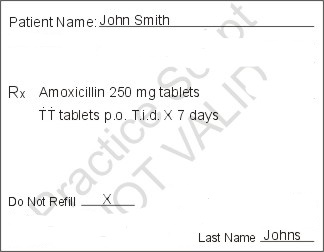

In [4]:
img = cv2.imread("/content/Inkedperfect_LI.jpg") 
cv2_imshow(img)
cv2.waitKey()
cv2.destroyAllWindows()

In [5]:
Prescription=pytesseract.image_to_string(img) 
print(Prescription)

 

 

Patient Name: John Smith

Rx Amoxicillin 250 mg tablets
TT tablets p.o. Tid. x 7 days

Do Not Refill __»

 

Last Name Johns _

 



In [6]:
%%bash
pip install numpy scipy librosa unidecode inflect librosa
apt-get update
apt-get install -y libsndfile1

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

Load the Tacotron2 model pre-trained on [LJ Speech dataset](https://keithito.com/LJ-Speech-Dataset/) and prepare it for inference:

In [7]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

Load pretrained WaveGlow model

In [8]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

Now, let's make the model say:

In [9]:
text = pytesseract.image_to_string(img)

Format the input using utility methods

In [10]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
sys:1: UserWarning: Unexpected character »: please revise your text cleaning rules.


Run the chained models:

In [11]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

You can write it to a file and listen to it

In [12]:
from scipy.io.wavfile import write
write("audio.wav", rate, audio_numpy)

In [13]:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)

### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Tacotron 2

*Author: NVIDIA*

**The Tacotron 2 model for generating mel spectrograms from text**

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" alt="alt" width="50%"/>



### Model Description

The Tacotron 2 and WaveGlow model form a text-to-speech system that enables user to synthesise a natural sounding speech from raw transcripts without any additional prosody information. The Tacotron 2 model produces mel spectrograms from input text using encoder-decoder architecture. WaveGlow (also available via torch.hub) is a flow-based model that consumes the mel spectrograms to generate speech.

This implementation of Tacotron 2 model differs from the model described in the paper. Our implementation uses Dropout instead of Zoneout to regularize the LSTM layers.

### Example

In the example below:
- pretrained Tacotron2 and Waveglow models are loaded from torch.hub
- Tacotron2 generates mel spectrogram given tensor represantation of an input text ("Hello world, I missed you so much")
- Waveglow generates sound given the mel spectrogram
- the output sound is saved in an 'audio.wav' file

To run the example you need some extra python packages installed.
These are needed for preprocessing the text and audio, as well as for display and input / output.

Alternatively, play it right away in a notebook with IPython widgets

### Details
For detailed information on model input and output, training recipies, inference and performance visit: [github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2) and/or [NGC](https://ngc.nvidia.com/catalog/resources/nvidia:tacotron_2_and_waveglow_for_pytorch)

### References

 - [Natural TTS Synthesis by Conditioning WaveNet on Mel Spectrogram Predictions](https://arxiv.org/abs/1712.05884)
 - [WaveGlow: A Flow-based Generative Network for Speech Synthesis](https://arxiv.org/abs/1811.00002)
 - [Tacotron2 and WaveGlow on NGC](https://ngc.nvidia.com/catalog/resources/nvidia:tacotron_2_and_waveglow_for_pytorch)
 - [Tacotron2 and Waveglow on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2)